In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import string
from nltk.corpus import stopwords
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE


# Download necessary NLTK resources
# nltk.download('punkt')
# nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Define directories for each dataset
directories = {
    'agoda_hotel_reviews': (1, 10),  
    'tripadvisor_hotel_reviews': (1, 5),
    'klook_hotel_reviews': (1, 5),  
    'booking_hotel_reviews': (1, 10)
}

In [2]:
# Function to load and normalize data
def load_and_normalize_data():
    all_reviews = []
    for directory, (min_score, max_score) in directories.items():           
        path = os.path.join('raw data', directory)
        for filename in os.listdir(path):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, filename))
                scaler = MinMaxScaler(feature_range=(0, 1))
                df['normalized_score'] = scaler.fit_transform(df[['Review Score']])
                all_reviews.append(df)
    return pd.concat(all_reviews, ignore_index=True)

# Load and normalize data
df = load_and_normalize_data()

In [3]:
# Function to lemmatize text
def preprocess_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()

    # Step 2: Remove punctuation
    # You can translate punctuation to None (removing it)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Step 3: Tokenization
    tokens = nltk.word_tokenize(text)

    # Step 4: Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Step 5: Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return the processed text as a single string
    return ' '.join(lemmatized_tokens)

# Lemmatize the review content
df['cleaned_content'] = df['Review Content'].apply(preprocess_text)

In [4]:
# Convert normalized scores to binary labels (1 for positive, 0 for negative)
df['label'] = df['normalized_score'].apply(lambda x: -1 if x <= 0.25 else (1 if x >= 0.75 else 0))
print(df['label'])
print(df.head())

print(df[['normalized_score', 'label']].describe())


0        1
1        1
2        1
3        1
4        1
        ..
10237    1
10238    1
10239    0
10240    1
10241    1
Name: label, Length: 10242, dtype: int64
  Review Provider  Review ID  \
0           Agoda  831639368   
1           Agoda  830646554   
2           Agoda  830862563   
3           Agoda  830828036   
4           Agoda  823596890   

                                      Review Content  Review Score  \
0  The hotel's facilities were top notch, from th...           9.6   
1  I enjoyed my stay at the Bai Hotel. The prices...          10.0   
2                        My favorite hotel\r\n \r\n           10.0   
3  This hotel was so accommodating. Good staff, g...          10.0   
4                         Well recommended\r\n \r\n           10.0   

                 Review Time  normalized_score  \
0  2024-07-16T09:26:00+07:00              0.95   
1  2024-07-15T12:05:00+07:00              1.00   
2  2024-07-15T07:56:00+07:00              1.00   
3  2024-07-15T04:07:00+0

In [5]:
# Count the occurrences of each label
positive_count = (df['label'] == 1).sum()
negative_count = (df['label'] == -1).sum()
neutral_count = (df['label'] == 0).sum()

# Print the counts
print(f'Positive reviews: {positive_count}')
print(f'Negative reviews: {negative_count}')
print(f'Neutral reviews: {neutral_count}')
print(f"Total: {df['label'].count()}")

Positive reviews: 8403
Negative reviews: 394
Neutral reviews: 1445
Total: 10242


In [6]:
label_mapping = {-1: 0, 0: 1, 1: 2}
df['encoded_label'] = df['label'].map(label_mapping)

In [14]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_content'])

word_index = tokenizer.word_index

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_content'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Prepare labels
labels = df['encoded_label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, stratify=labels, random_state=42)

# Instantiate the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape)
print(y_resampled.shape)



(17646, 100)
(17646,)


Epoch 1/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.5625 - loss: 1.0047 - val_accuracy: 0.0000e+00 - val_loss: 1.7515
Epoch 2/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.7440 - loss: 0.6525 - val_accuracy: 0.0326 - val_loss: 1.7410
Epoch 3/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8123 - loss: 0.4813 - val_accuracy: 0.1465 - val_loss: 1.8029
Epoch 4/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.8635 - loss: 0.3819 - val_accuracy: 0.3167 - val_loss: 1.6811
Epoch 5/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8994 - loss: 0.2883 - val_accuracy: 0.2244 - val_loss: 2.3043
Epoch 6/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9306 - loss: 0.2144 - val_accuracy: 0.2569 - val_loss: 2.2356
Epoch 7/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.9461 - loss: 0.1755 - val_accuracy: 0.3983 - val_loss: 1.9128
Epoch 8/20
442/442 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.9645 - loss: 0.117

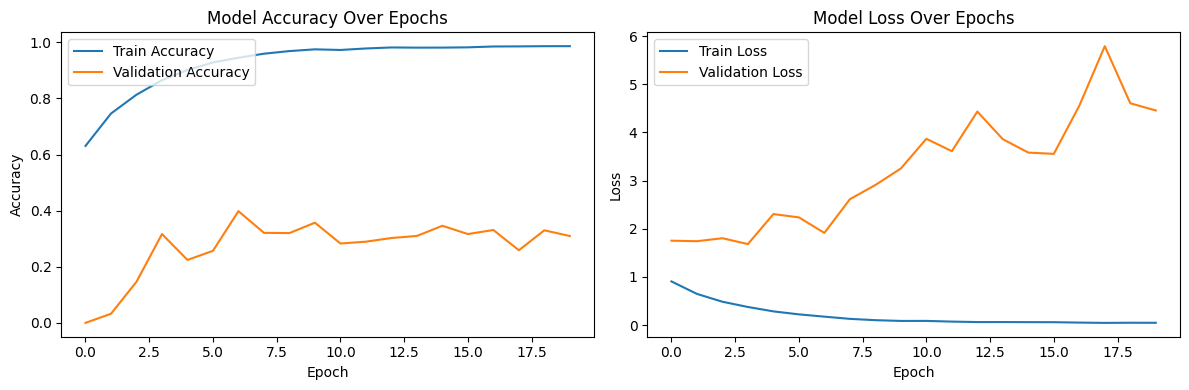

In [13]:
# Model creation
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Corrected placement
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes for multi-class classification
])

# Model Compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
history = model.fit(X_resampled, y_resampled, epochs=20, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')  # Rounded to 4 decimal places for clarity

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example input reviews
new_reviews = [
    {"review": "The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!", "score": 1.0},
    {"review": "The location was good, but the room had a strange smell and the service was just okay.", "score": 0.6},
    {"review": "I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.", "score": 0.2},
    {"review": "Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.", "score": 1.0},
    {"review": "The room was decent, but the Wi-Fi was slow and unreliable. It was an average stay overall.", "score": 0.5},
    {"review": "Terrible service! We waited over an hour for our room to be ready and the staff was not apologetic.", "score": 0.3},
    {"review": "The hotel was in a perfect location, close to all the major attractions. The room was comfortable and well-maintained.", "score": 0.9},
    {"review": "The facilities were outdated, and the air conditioning barely worked. I was disappointed with my stay.", "score": 0.4},
    {"review": "Great value for money! The hotel offered a lot of amenities and the staff was very friendly.", "score": 0.8},
    {"review": "The breakfast was good, but the room was small and the bed was uncomfortable. It was an okay stay.", "score": 0.6}
]

# Define a function to preprocess new input data
def preprocess_new_data(new_data):
    # Apply the same preprocessing function
    cleaned_data = [preprocess_text(entry["review"]) for entry in new_data]
    
    # Convert to sequences using the trained tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    
    # Pad the sequences
    padded_sequences = pad_sequences(sequences, maxlen=100)  # Use the same maxlen as your training data

    return padded_sequences

# Prepare reviews for prediction
padded_sequences = preprocess_new_data(new_reviews)

# Make predictions
predictions = model.predict(padded_sequences)

# Interpreting the predictions
for i, prediction in enumerate(predictions):
    predicted_label = np.argmax(prediction)  # Get the index of the highest probability
    predicted_score = prediction[predicted_label]  # The probability of the predicted class
    actual_score = new_reviews[i]["score"]

    # Assign sentiment based on the predicted label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    sentiment = sentiment_labels[predicted_label]

    # Print the results
    print(f"Review: {new_reviews[i]['review']}")
    print(f"Actual Score: {actual_score:.2f}")
    print(f"Predicted Label: {sentiment}")
    print(f"Negative Probability: {prediction[0]:.2f}")
    print(f"Neutral Probability: {prediction[1]:.2f}")
    print(f"Positive Probability: {prediction[2]:.2f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Review: The hotel staff was incredibly helpful and the room was clean and spacious. Definitely a positive experience!
Actual Score: 1.00
Predicted Label: Positive
Negative Probability: 0.00
Neutral Probability: 0.01
Positive Probability: 0.99
--------------------------------------------------
Review: The location was good, but the room had a strange smell and the service was just okay.
Actual Score: 0.60
Predicted Label: Neutral
Negative Probability: 0.05
Neutral Probability: 0.95
Positive Probability: 0.00
--------------------------------------------------
Review: I had a terrible stay. The room was dirty and the staff was rude. Not worth the price.
Actual Score: 0.20
Predicted Label: Neutral
Negative Probability: 0.42
Neutral Probability: 0.58
Positive Probability: 0.00
--------------------------------------------------
Review: Amazing experience! The view from the room was breathtaking and the food at the restaurant was top-notch.
Actual Score: 1.

In [ ]:
from datetime import datetime
import os

# Assuming `model` is your Keras model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'saved_models/general_sentiment_softmax_{timestamp}.keras'

# Make sure the directory exists
os.makedirs(os.path.dirname(file_name), exist_ok=True)

# Save the model with the unique file name
model.save(file_name)
print(f"Model saved as {file_name}")
model.summary()

Model saved as saved_models/general_sentiment_softmax_20240825_002342.keras


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 96, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,563,019 (9.78 MB)

 Trainable params: 854,339 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,708,680 (6.52 MB)